# Outline
1. Get the correct tiles to input into the image

# 1. Get the right tile

In [23]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image, ImageDraw

In [24]:
tile_coords = pd.read_csv('data/tile_coords.csv')

In [25]:
def get_tile(tile_coords, lat, lon):
    lon_range = lon > tile_coords.iloc[:, 1]
    lat_range = lat > tile_coords.iloc[:, 2]

    for row in range(len(tile_coords)):
        if lon_range[row] == True and lat_range[row] == True:
            return f'img_{row:02.0f}.jpeg', tile_coords.drop('image_name', axis=1).iloc[row].tolist()

    print('Coordinates do not match any tile')

In [26]:
# For 376 Utica Ln
target_lat, target_lon = 37.231890384715285, -121.8061249173905
tile_img, bb = get_tile(tile_coords, target_lat, target_lon)
tile_img, bb

('img_00.jpeg',
 [-121.806611, 37.231278, -121.8060334236414, 37.231625708570505])

# 2. Pass the tile to the model

In [27]:
def coords_to_img(lat, lon):
    tile_coords = pd.read_csv('data/tile_coords.csv')
    tile_img, bb = get_tile(tile_coords, lat, lon)
    check_point = "google/owlv2-base-patch16-ensemble"
    model = AutoModelForZeroShotObjectDetection.from_pretrained(check_point)
    processor = AutoProcessor.from_pretrained(check_point)

    im = Image.open(f'data/{tile_img}')
    queries = ['house', 'solar panel', 'pool']
    input = processor(text=queries, images=im, return_tensors='pt')

    with torch.no_grad():
        outputs = model(**input)
        target_sizes = torch.tensor([im.size[::-1]])
        results = processor.post_process_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[0]

    min_lon, min_lat, max_lon, max_lat = bb[0], bb[1], bb[2], bb[3]
    if target_lat > max_lat:
        img_lat = max_lat
    elif target_lat < min_lat:
        img_lat = min_lat
    else:
        img_lat = target_lat

    if target_lon > max_lon:
        img_lon = max_lon
    elif target_lon < min_lon:
        img_lon = min_lon
    else:
        img_lon = target_lon

    delta_lon = (img_lon - min_lon) * 1024 / (max_lon - min_lon)
    delta_lat = (max_lat - img_lat) * 1024 / (max_lat - min_lat)

    draw = ImageDraw.Draw(im)
    
    scores = results['scores'].tolist()
    labels = results['labels'].tolist()
    boxes = results['boxes'].tolist()

    for box, score, label in zip(boxes, scores, labels):
        xmin, ymin, xmax, ymax = box
        draw.rectangle((xmin, ymin, xmax, ymax), outline="#39ff14", width=2)
        draw.text((xmin, ymin), f"{queries[label]}: {round(score,2)}", fill="white")

    im

In [28]:
check_point = "google/owlv2-base-patch16-ensemble"
model = AutoModelForZeroShotObjectDetection.from_pretrained(check_point)
processor = AutoProcessor.from_pretrained(check_point)

In [29]:
im = Image.open(f'data/{tile_img}')
queries = ['house', 'solar panel', 'pool']
input = processor(text=queries, images=im, return_tensors='pt')

In [30]:
with torch.no_grad():
    outputs = model(**input)
    target_sizes = torch.tensor([im.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[0]

In [31]:
draw = ImageDraw.Draw(im)

scores = results['scores'].tolist()
labels = results['labels'].tolist()
boxes = results['boxes'].tolist()

In [32]:
results

{'scores': tensor([0.3850, 0.3467, 0.4835, 0.2102, 0.2790, 0.2838, 0.3271, 0.4979, 0.2139,
         0.2021, 0.4011, 0.4243, 0.2554, 0.2688, 0.2668, 0.2033, 0.2718, 0.3086,
         0.3393, 0.3410, 0.2522, 0.2478, 0.2402, 0.2241, 0.2152, 0.3160, 0.3561,
         0.3469]),
 'labels': tensor([0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
         0, 0, 0, 0]),
 'boxes': tensor([[3.4533e+02, 2.2743e+01, 5.0468e+02, 1.6790e+02],
         [5.9967e+02, 3.9606e+01, 7.4670e+02, 1.8864e+02],
         [5.4356e+02, 1.2705e+02, 5.9990e+02, 2.2995e+02],
         [9.1847e+01, 1.8083e+02, 4.1235e+02, 3.8962e+02],
         [2.5619e+02, 1.7513e+02, 4.0962e+02, 3.2305e+02],
         [6.3607e+02, 1.7429e+02, 8.1162e+02, 3.5598e+02],
         [1.1802e+02, 2.3058e+02, 2.7455e+02, 3.7931e+02],
         [4.0321e+02, 2.2444e+02, 4.6473e+02, 2.8989e+02],
         [8.6518e+02, 1.6909e+02, 1.0034e+03, 3.7294e+02],
         [5.7756e+01, 3.1393e+02, 1.0706e+02, 3.8809e+02],
         [6.752

In [34]:
target_lat, target_lon
bb

max_lat, min_lat = bb[3], bb[1]
max_lon, min_lon = bb[2], bb[0]

if target_lat > max_lat:
    img_lat = max_lat
elif target_lat < min_lat:
    img_lat = min_lat
else:
    img_lat = target_lat

if target_lon > max_lon:
    img_lon = max_lon
elif target_lon < min_lon:
    img_lon = min_lon
else:
    img_lon = target_lon

In [35]:
delta_lon = (img_lon - min_lon) * 1024 / (max_lon - min_lon)
delta_lat = (max_lat - img_lat) * 1024 / (max_lat - min_lat)

delta_lon, delta_lat

(861.7883760431856, 0.0)

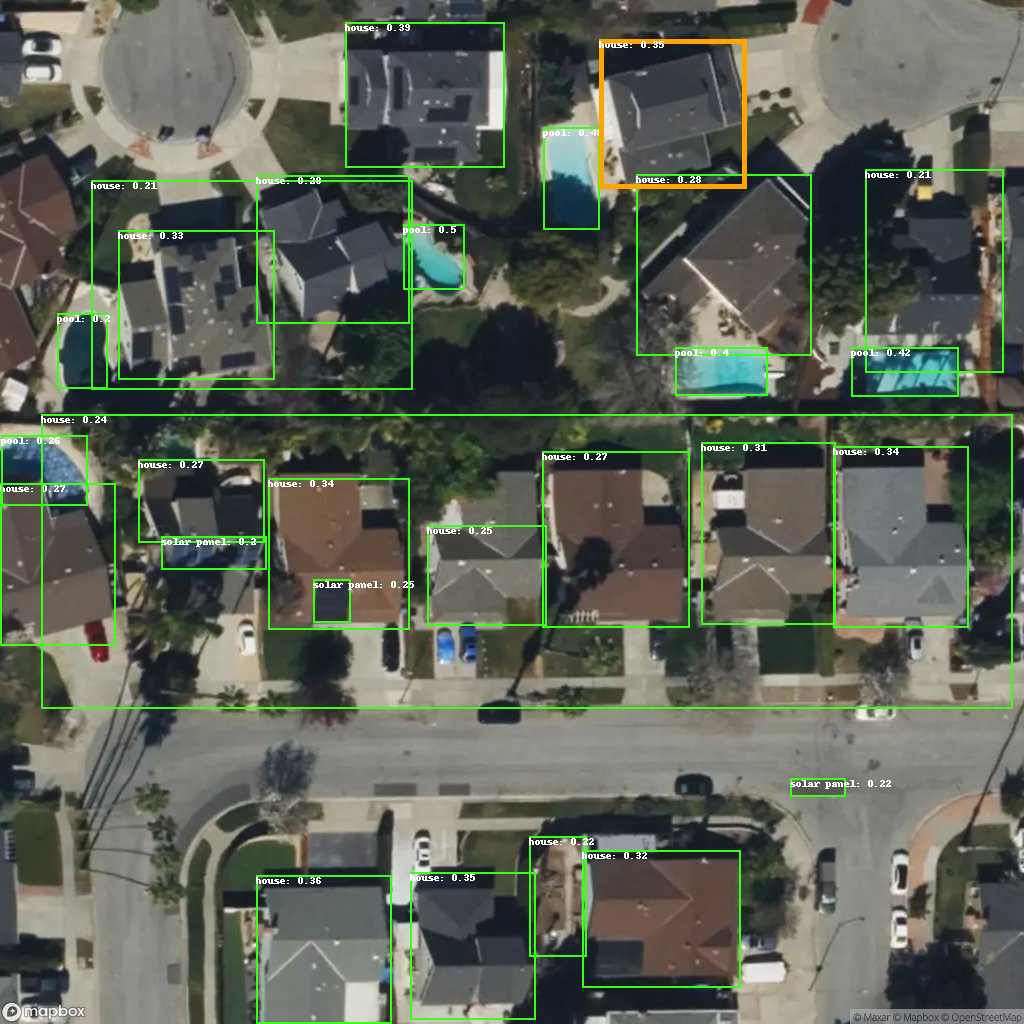

In [41]:
box_centers = list()
for idx, (box, score, label) in enumerate(zip(boxes, scores, labels)):
    xmin, ymin, xmax, ymax = box
    if label != 0:
        draw.rectangle((xmin, ymin, xmax, ymax), outline="#39ff14", width=2)
        draw.text((xmin, ymin), f"{queries[label]}: {round(score,2)}", fill="white")
    else:
        center = (xmax + xmin)/2, (ymax + ymin)/2
        box_centers.append((idx, score, center))

closest = sorted(box_centers, key=lambda x: np.sqrt((x[2][0]-delta_lon)**2 + (x[2][1]-delta_lat)**2))[0][0]
x_min, y_min, x_max, y_max = boxes[closest]
draw.rectangle((x_min, y_min, x_max, y_max), outline='orange', width=5)
lab = labels[closest]
draw.text((x_min, y_min), f"{queries[lab]}: {round(score,2)}", fill="white")

im

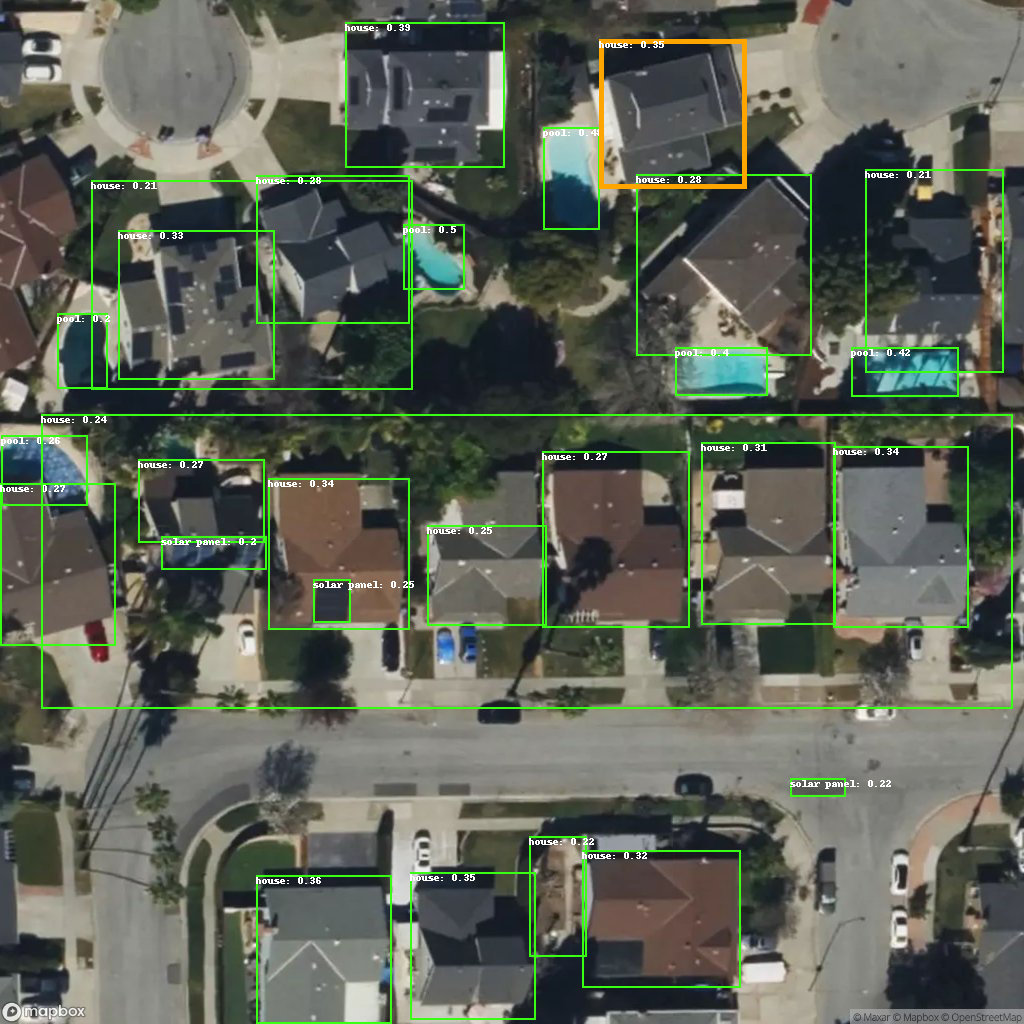

In [40]:
for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="#39ff14", width=2)
    draw.text((xmin, ymin), f"{queries[label]}: {round(score,2)}", fill="white")

draw.rectangle((x_min, y_min, x_max, y_max), outline='orange', width=5)
lab = labels[closest]
draw.text((x_min, y_min), f"{queries[lab]}: {round(score,2)}", fill="white")

im